ForcePhotZTF products have already been moved to `targetdir`. See Yao et al. (2019) for the software.

### 1. Read the data and quick look light curve

In [123]:
import numpy as np
import pandas as pd
from astropy.table import Table

import matplotlib
import matplotlib.pyplot as plt
fs = 12
matplotlib.rcParams['font.size']=fs

In [124]:
def read_mcmc_lc(name, targetdir, suffix = '_info_ref.fits'):
    info_file = targetdir+'lightcurves/force_phot_{}'.format(name)+suffix
    # xy_file = targetdir+'lightcurves/xydata_{}.fits'.format(name)
    
    info_tbl = Table.read(info_file)
    # xy_tbl = Table.read(xy_file)
    info_df = info_tbl.to_pandas()
    # xy_df = xy_tbl.to_pandas()

    mylc = pd.read_hdf(targetdir+'lightcurves/'+name+'_force_phot_nob.h5')
    mylc['jdref_start'] = info_df['jdref_start'].values
    mylc['jdref_end'] = info_df['jdref_end'].values

    mylc['fcqfid'] = mylc['fieldid']*10000 + mylc['ccdid']*100 + mylc['qid']*10 + mylc['filterid']
    tb = mylc
    F0 = 10**(tb['zp'].values/2.5)
    eF0 = F0 / 2.5 * np.log(10) * tb['ezp'].values
    Fpsf = tb['Fmcmc'].values
    eFpsf = tb['Fmcmc_unc'].values
    Fratio = Fpsf / F0
    eFratio2 = (eFpsf / F0)**2 + (Fpsf * eF0 / F0**2)**2
    eFratio = np.sqrt(eFratio2)
    tb['Fratio'] = Fratio
    tb['Fratio_unc'] = eFratio
    
    tb['diffimgname'] = [x.decode("utf-8") for x in tb['diffimgname'].values]
    return tb

In [125]:
targetdir = "../data/photometry/P48/forcephot_product/"
name = "ZTF18abfcmjw"

mylc = read_mcmc_lc(name, targetdir)

mylc.head()

,jdobs,filter,seeing,gain,zp,ezp,programid,fieldid,ccdid,qid,...,Fmcmc_low_2sigma,Fmcmc_low_1sigma,Fmcmc_high_3sigma,Fmcmc_high_2sigma,Fmcmc_high_1sigma,Fratio,Fratio_unc,jdref_start,jdref_end,fcqfid
0,2.458223e+06,b'r',2.429,5.632374,26.275,0.000002,2.0,763.0,14.0,3.0,...,-109.201345,-78.721894,44.234665,12.582793,-17.761142,-1.491929e-09,9.419337e-10,2.458155e+06,2.458220e+06,7631432.0
1,2.458223e+06,b'r',2.827,5.675090,26.275,0.000003,2.0,763.0,14.0,3.0,...,-91.274318,-56.091320,84.272529,49.218817,14.071662,-6.458695e-10,1.084122e-09,2.458155e+06,2.458220e+06,7631432.0
2,2.458223e+06,b'r',2.077,5.673160,26.275,0.000002,1.0,763.0,14.0,3.0,...,-51.814189,-28.986826,64.383551,39.419393,16.280494,-1.986928e-10,6.994470e-10,2.458155e+06,2.458220e+06,7631432.0
3,2.458223e+06,b'r',2.205,5.696431,26.275,0.000002,2.0,763.0,14.0,3.0,...,0.178895,24.887156,124.914196,99.181362,74.136753,1.531705e-09,7.609790e-10,2.458155e+06,2.458220e+06,7631432.0
4,2.458225e+06,b'r',2.739,5.489145,26.275,0.000003,2.0,763.0,14.0,3.0,...,-107.019875,-76.333891,46.912153,15.575940,-15.273913,-1.418786e-09,9.434668e-10,2.458155e+06,2.458220e+06,7631432.0


In [126]:
len(mylc)

1463

In [127]:
mylc.columns

Index(['jdobs', 'filter', 'seeing', 'gain', 'zp', 'ezp', 'programid',
       'fieldid', 'ccdid', 'qid', 'filterid', 'moonra', 'moondec', 'moonillf',
       'moonphase', 'airmass', 'nbad', 'nbadbkg', 'bkgstd', 'bkgmed',
       'diffimgname', 'psfimgname', 'Fmcmc', 'Fmcmc_unc', 'Fmcmc_low_3sigma',
       'Fmcmc_low_2sigma', 'Fmcmc_low_1sigma', 'Fmcmc_high_3sigma',
       'Fmcmc_high_2sigma', 'Fmcmc_high_1sigma', 'Fratio', 'Fratio_unc',
       'jdref_start', 'jdref_end', 'fcqfid'],
      dtype='object')

In [128]:
def plotlcs(tb, name, targetdir, seeing_cut = 7.,Fratiounc_cut = 1e-7, show_refjds = True):
    tb = tb[tb.seeing<seeing_cut]
    tb = tb[tb.Fratio_unc<Fratiounc_cut]
    
    fcqfs = np.unique(tb['fcqfid'].values)
    
    colors_g = ['limegreen', 'c', 'skyblue']
    colors_r = ['r', 'm', 'pink']
    colors_i = ['gold', 'orange', 'y']
        
    plt.figure(figsize=(9,6))
    for fcqfid in fcqfs:
        ix = tb['fcqfid'].values==fcqfid
        if fcqfid % 10 ==1:
            color=colors_g[0]
            colors_g = colors_g[1:]
        elif fcqfid % 10 == 2:
            color=colors_r[0]
            colors_r = colors_r[1:]
        else:
            color=colors_i[0]
            colors_i = colors_i[1:]
        thistime = (tb['jdobs'][ix] - 2458000)
        plt.errorbar(thistime, tb['Fratio'][ix], tb['Fratio_unc'][ix], 
                     fmt='.', color=color, label = 'fcqfid = %d, Nobs = %d'%(fcqfid, np.sum(ix)))
        
    ix = tb["fieldid"]==763
    ixrise = (tb['jdobs'][ix] > 2458580)&(tb['jdobs'][ix] < 2458590)
    print ("%d data along the rise"%np.sum(ixrise))
        
    ax = plt.gca()
    ylims1 = ax.get_ylim()
    
    # plot the duration of refernce image taken period...
    if show_refjds==True:
        
        yupper = ylims1[0] + 0.95 * (ylims1[1]-ylims1[0])
        ylower = ylims1[0] + 0.85 * (ylims1[1]-ylims1[0])
        yposes = np.linspace(ylower, yupper, len(fcqfs))
        
        colors_g = ['limegreen', 'c', 'skyblue']
        colors_r = ['r', 'm', 'pink']
        colors_i = ['gold', 'orange', 'y']
        
        for j in range(len(fcqfs)):
            fcqfid = fcqfs[j]
            ix = tb['fcqfid'].values==fcqfid
            if fcqfid % 10 ==1:
                color=colors_g[0]
                colors_g = colors_g[1:]
            elif fcqfid % 10 == 2:
                color=colors_r[0]
                colors_r = colors_r[1:]
            else:
                color=colors_i[0]
                colors_i = colors_i[1:]
            jdstart = tb['jdref_start'].values[ix][0]
            jdend = tb['jdref_end'].values[ix][0]
            ypos = yposes[j]
            plt.plot([jdstart-2458000, jdend-2458000], [ypos, ypos], '-', color = color)    
            t0 = Time(jdstart, format = "jd")
            t1 = Time(jdend, format = "jd")
            print (fcqfid, t0.datetime64, t1.datetime64)
        
    plt.ylim(ylims1[0], ylims1[1])
    plt.grid(ls=":")
    plt.xlabel('JD - 2458000 (days)')
    plt.ylabel('f/f0')
    plt.legend(loc = 'best')
    plt.title(name)
    plt.tight_layout()

In [129]:
%matplotlib notebook

<IPython.core.display.Javascript object>


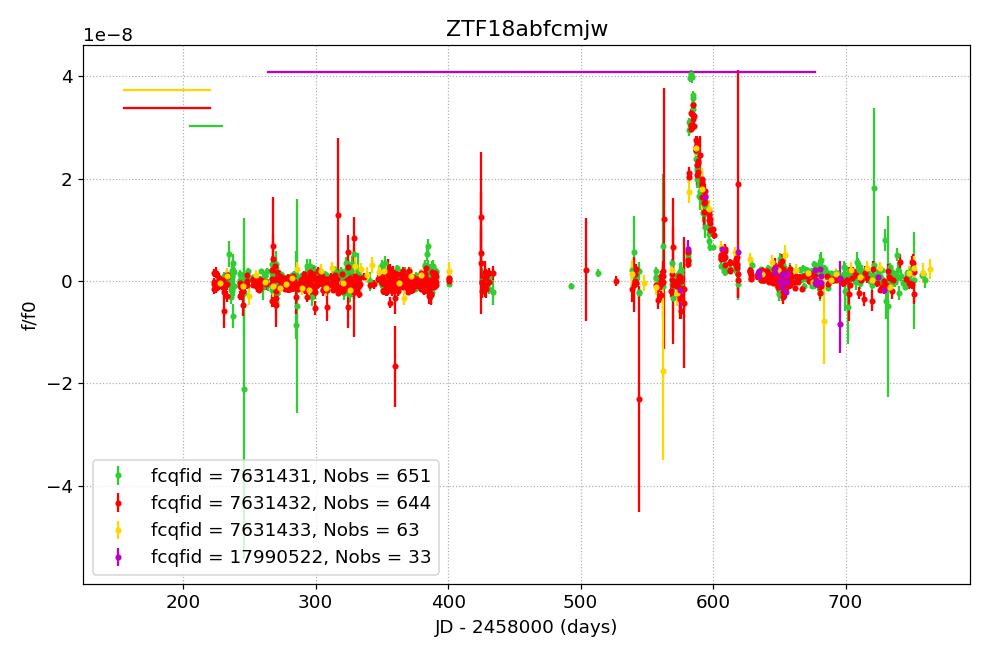

48 data along the rise
7631431.0 2018-03-27T10:26:20.999980867 2018-04-20T11:53:55.134990513
7631432.0 2018-02-05T13:26:42.999982238 2018-04-11T12:01:58.000003695
7631433.0 2018-02-05T13:26:42.999982238 2018-04-11T12:01:58.000003695
17990522.0 2018-05-25T08:19:29.282989204 2019-07-12T05:30:15.534000099


In [130]:
plotlcs(mylc, name, targetdir, seeing_cut = 3., Fratiounc_cut=4e-8, show_refjds = True)

It is clear that we should exclude field 1799.

In [9]:
mylc = mylc[mylc.fieldid!=1799]

In [10]:
len(mylc)

1428

In [11]:
#plotlcs(mylc, name, targetdir, seeing_cut = 3., Fratiounc_cut=7e-9, show_refjds = False)

Baseline end point: following Yao et al. (2019), choose $T_{\rm before}=20$.

In [12]:
tmax = mylc.loc[mylc['Fratio'].idxmax(), 'jdobs']
base_end = tmax - 20

base_end

# Confirmed that this is not in the middle of a night

mylc = mylc[mylc.seeing < 3]

mylc = mylc[mylc.Fratio_unc < 7e-9]

len(mylc)

tbb = mylc[mylc.jdobs<base_end]
tba = mylc[mylc.jdobs>=base_end]

### 2. consider baseline correction

In [13]:
ixg = tbb["filterid"].values==1
ixr = tbb["filterid"].values==2
ixi = tbb["filterid"].values==3

In [14]:
fcqfs = np.unique(tbb['fcqfid'].values)   
multiply_factors = np.ones(len(fcqfs))*(-999)
offset_wgtmeans = np.ones(len(fcqfs))*(-999)
    
for i in range(len(fcqfs)):
    fcqfid = fcqfs[i]
    dfnow = tbb[tbb.fcqfid==fcqfid]
    data = dfnow['Fmcmc'].values
    data_unc = dfnow['Fmcmc_unc'].values
    ndata = len(data)
    print ("fcqfid = %d, Ndata = %d"%(np.int(fcqfid), ndata))
        
    if ndata<30:
        print ("    Ndata is too small: nothing should be done")
        pass
    else:
        weight = 1/data_unc**2
        dtweightedmean = np.sum(data*weight) / np.sum(weight)
        offset_wgtmeans[i] = dtweightedmean
        print ('   weighted mean: %.2f'%dtweightedmean)
        ddd111 = (data - dtweightedmean) / data_unc
        chi2 = (ddd111)**2
        chi2_dof = np.sum(chi2) / (len(data) - 1)
        multifac = np.sqrt(chi2_dof)
        multiply_factors[i] = multifac
        print ('    multiply factor: %.2f'%multifac)

fcqfid = 7631431, Ndata = 376
   weighted mean: 14.45
    multiply factor: 1.29
fcqfid = 7631432, Ndata = 405
   weighted mean: -11.24
    multiply factor: 1.28
fcqfid = 7631433, Ndata = 32
   weighted mean: 6.40
    multiply factor: 1.20


<IPython.core.display.Javascript object>


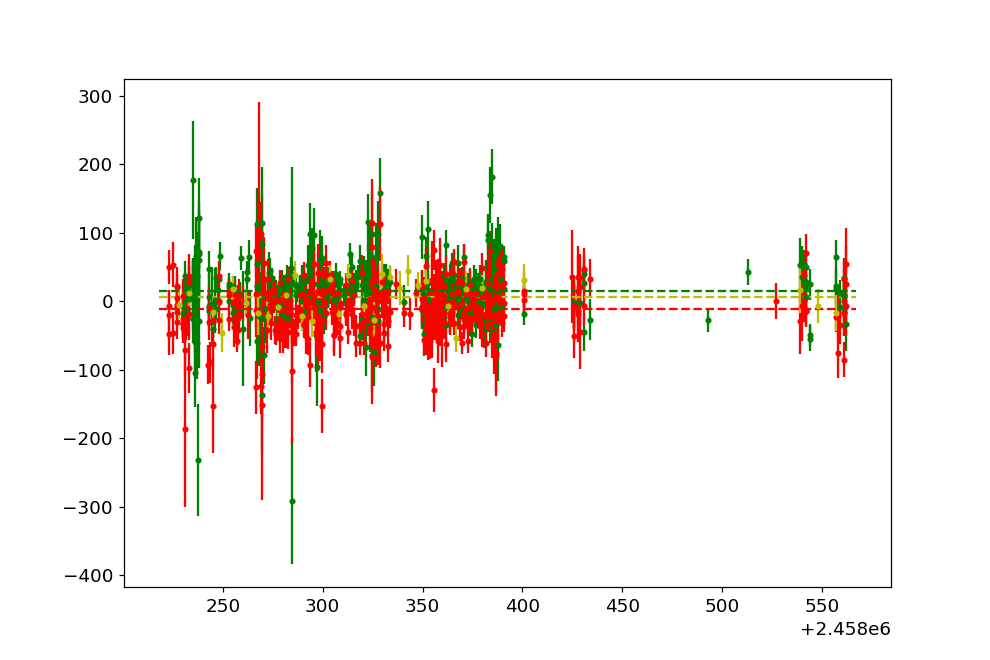

In [15]:
plt.figure(figsize=(9, 6))
plt.errorbar(tbb["jdobs"].values[ixg], tbb["Fmcmc"].values[ixg], tbb["Fmcmc_unc"].values[ixg], fmt = ".g")
plt.errorbar(tbb["jdobs"].values[ixr], tbb["Fmcmc"].values[ixr], tbb["Fmcmc_unc"].values[ixr], fmt = ".r")
plt.errorbar(tbb["jdobs"].values[ixi], tbb["Fmcmc"].values[ixi], tbb["Fmcmc_unc"].values[ixi], fmt = ".y")
jd0 = min(tbb["jdobs"].values)-5
jd1 = max(tbb["jdobs"].values)+5
plt.hlines(offset_wgtmeans[0], jd0, jd1, linestyle='--', color = 'g')
plt.hlines(offset_wgtmeans[1], jd0, jd1, linestyle='--', color = 'r')
plt.hlines(offset_wgtmeans[2], jd0, jd1, linestyle='--', color = 'y')

<IPython.core.display.Javascript object>


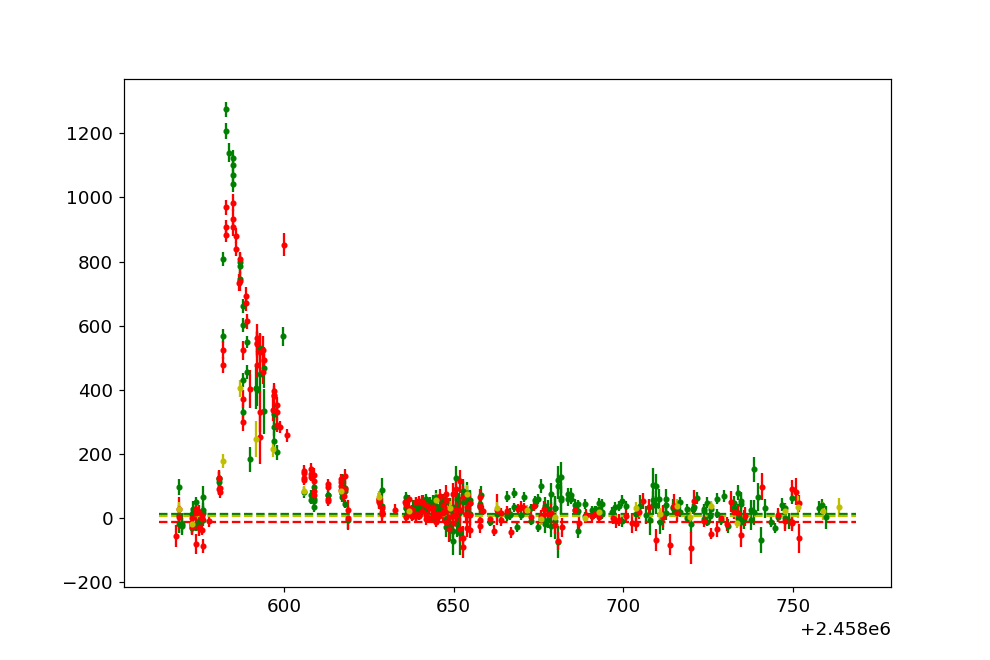

In [16]:
ixg = tba["filterid"].values==1
ixr = tba["filterid"].values==2
ixi = tba["filterid"].values==3
plt.figure(figsize=(9, 6))
plt.errorbar(tba["jdobs"].values[ixg], tba["Fmcmc"].values[ixg], tba["Fmcmc_unc"].values[ixg], fmt = ".g")
plt.errorbar(tba["jdobs"].values[ixr], tba["Fmcmc"].values[ixr], tba["Fmcmc_unc"].values[ixr], fmt = ".r")
plt.errorbar(tba["jdobs"].values[ixi], tba["Fmcmc"].values[ixi], tba["Fmcmc_unc"].values[ixi], fmt = ".y")
jd0 = min(tba["jdobs"].values)-5
jd1 = max(tba["jdobs"].values)+5
plt.hlines(offset_wgtmeans[0], jd0, jd1, linestyle='--', color = 'g')
plt.hlines(offset_wgtmeans[1], jd0, jd1, linestyle='--', color = 'r')
plt.hlines(offset_wgtmeans[2], jd0, jd1, linestyle='--', color = 'y')

In [17]:
tba = tba.drop(columns=['Fmcmc_low_3sigma', 'Fmcmc_low_2sigma', 'Fmcmc_low_1sigma', 'Fmcmc_high_3sigma', 'Fmcmc_high_2sigma', 'Fmcmc_high_1sigma'])

tba = tba.drop(columns=["airmass", "moonphase", "nbad", 'nbadbkg', 'bkgstd', 'bkgmed'])

tba = tba.drop(columns=['moonra', 'moondec', 'moonillf', 'Fratio', 'Fratio_unc'])

offset = np.ones(len(tba))*(-999)
multiply = np.ones(len(tba))*(-999)
temp = tba['fcqfid'].values
fcqfs_all = np.unique(temp)

for i in range(len(fcqfs_all)):
    fcqfid = fcqfs_all[i]
    ind = np.where(fcqfs==fcqfid)[0][0]
    ix = temp==fcqfid
    offset[ix] = offset_wgtmeans[ind]
    multiply[ix] = multiply_factors[ind]

F0 = 10**(tba['zp'].values/2.5)
F0_unc = F0 / 2.5 * np.log(10) * tba['ezp'].values

Fmcmc = tba['Fmcmc'].values - offset
Fmcmc_unc = tba['Fmcmc_unc'].values * multiply
    
Fratio = Fmcmc / F0
Fratio_unc = np.hypot( Fmcmc_unc/F0, Fmcmc*F0_unc / F0**2 )
    
tba['Fratio'] = Fratio
tba['Fratio_unc'] = Fratio_unc

tba = tba.drop(columns=['Fmcmc', 'Fmcmc_unc'])

In [18]:
tba = tba.drop(columns=['seeing', 'gain', 'zp', 'ezp', 'fieldid', 'ccdid', 'qid', 'jdref_start', 'jdref_end', 'fcqfid'])

tba["mjd"] = tba["jdobs"].values - 2400000.5

In [19]:
def bin_single_night(xg, yg, yg_unc):
    xmin = np.rint(xg)[0]-1
    xmax = np.rint(xg)[-1]+1
    xleft = np.linspace(xmin, xmax-1, int(xmax-xmin))
    xright = np.linspace(xmin+1, xmax, int(xmax-xmin))
    
    a1 = []
    b1 = []
    c1 = []
    for i in range(len(xleft)):
        ix = (xg > xleft[i]) & (xg < xright[i])
        anow = xg[ix]
        bnow = yg[ix]
        cnow = yg_unc[ix]
        if len(anow) == 0:
            continue
        a1.append(np.mean(anow))
        weight = 1 / cnow**2
        bweight = np.sum(bnow * weight) / np.sum(weight)
        cweight = 1 / np.sqrt(np.sum(weight))
        b1.append(bweight)
        c1.append(cweight)
    a1 = np.array(a1)
    b1 = np.array(b1)
    c1 = np.array(c1)
    """
    plt.figure(figsize=(9,6))
    plt.errorbar(xg, yg, yg_unc, fmt='.k')
    plt.figure(figsize=(9,6))
    plt.errorbar(a1, b1, c1, fmt='.r')
    """
    return a1, b1, c1

def generate_binned_lc(mytb, plot_fig=True):
    mytbg = mytb[mytb.filterid==1]
    mytbr = mytb[mytb.filterid==2]
    mytbi = mytb[mytb.filterid==3]
    
    a1, b1, c1 = bin_single_night(mytbg['mjd'].values, mytbg['Fratio'].values, mytbg['Fratio_unc'].values)
    a2, b2, c2 = bin_single_night(mytbr['mjd'].values, mytbr['Fratio'].values, mytbr['Fratio_unc'].values)
    a3, b3, c3 = bin_single_night(mytbi['mjd'].values, mytbi['Fratio'].values, mytbi['Fratio_unc'].values)
    
    a12 = np.hstack([a1, a2, a3])
    b12 = np.hstack([b1, b2, b3])
    c12 = np.hstack([c1, c2, c3])
    fids = np.hstack([np.ones(len(a1)), np.ones(len(a2))*2, np.ones(len(a3))*3])
    
    newlc = Table(data = [a12, b12, c12, fids],
                  names = ['mjd', 'Fratio', 'Fratio_unc', 'filterid'])
    
    if plot_fig==True:
        plt.figure(figsize=(9,6))
        ax1 = plt.subplot(111)
        ax1.errorbar(a1-58570, b1, c1, fmt='.g')
        ax1.errorbar(a2-58570, b2, c2, fmt='.r')
        ax1.errorbar(a3-58570, b3, c3, fmt='.y')
        
        ax1.grid(ls=":")
        ax1.set_xlabel('mjd-58570')
        ax1.set_ylabel('Fratio')
        plt.tight_layout()
    return newlc

In [20]:
tba.head()

,jdobs,filter,programid,filterid,diffimgname,psfimgname,Fratio,Fratio_unc,mjd
892,2.458568e+06,b'r',1.0,2.0,ztf_20190325532535_000763_zr_c14_o_q3_scimrefd...,b'ztf_20190325532535_000763_zr_c14_o_q3_diffim...,-1.502802e-09,1.458437e-09,58567.532535
893,2.458569e+06,b'g',2.0,1.0,ztf_20190326411482_000763_zg_c14_o_q3_scimrefd...,b'ztf_20190326411482_000763_zg_c14_o_q3_diffim...,2.913611e-09,1.165777e-09,58568.411482
894,2.458569e+06,b'g',2.0,1.0,ztf_20190326427002_000763_zg_c14_o_q3_scimrefd...,b'ztf_20190326427002_000763_zg_c14_o_q3_diffim...,-1.147484e-09,1.210619e-09,58568.427026
895,2.458569e+06,b'g',2.0,1.0,ztf_20190326445463_000763_zg_c14_o_q3_scimrefd...,b'ztf_20190326445463_000763_zg_c14_o_q3_diffim...,-1.316490e-10,1.097378e-09,58568.445486
896,2.458569e+06,b'i',2.0,3.0,ztf_20190326476042_000763_zi_c14_o_q3_scimrefd...,b'ztf_20190326476042_000763_zi_c14_o_q3_diffim...,1.687476e-09,2.059941e-09,58568.476042


<IPython.core.display.Javascript object>


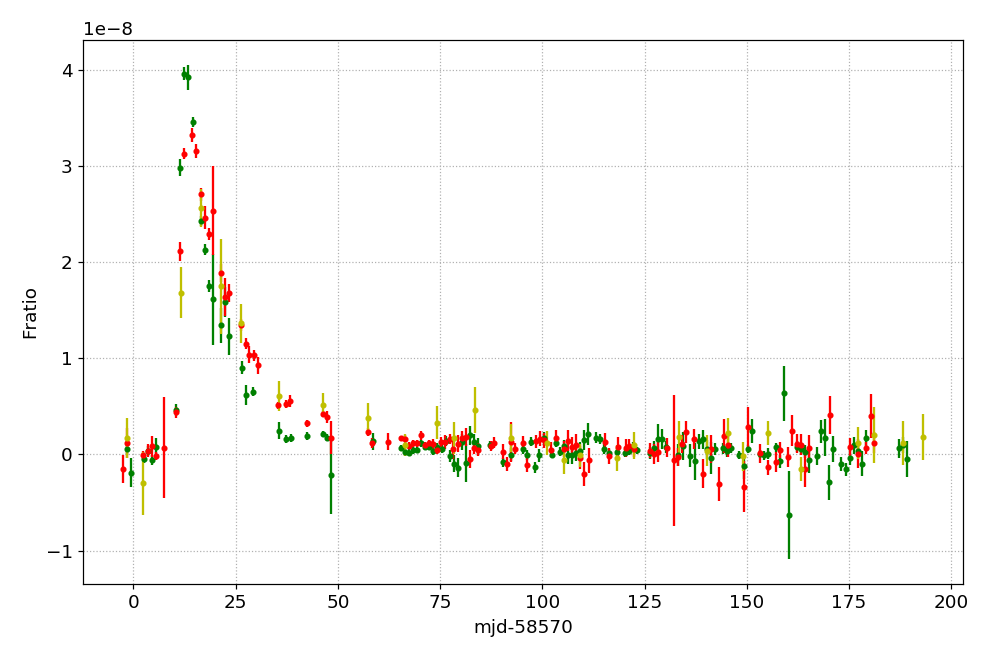

In [21]:
newlc = generate_binned_lc(tba, plot_fig=True)

In [22]:
newlc = newlc.to_pandas()

In [23]:
newlc.head()

,mjd,Fratio,Fratio_unc,filterid
0,58568.427998,5.566371e-10,6.668843e-10,1.0
1,58569.429549,-1.889837e-09,1.469067e-09,1.0
2,58572.502491,-5.095498e-10,4.245363e-10,1.0
3,58573.482679,3.398476e-10,5.239076e-10,1.0
4,58574.433137,-5.597584e-10,5.326942e-10,1.0


### Binning at late-time
MJD - 58570: starting from day 66, try binning every x days

In [24]:
def see_mags(mytb, SNT = 3, xlabel = "jdobs"):
    
    if xlabel == "jdobs":
        xoff = 2458570.5
    elif xlabel == "mjd":
        xoff = 58570
        
    Fratio = mytb["Fratio"].values
    Fratio_unc = mytb["Fratio_unc"].values
    ix = Fratio > SNT*Fratio_unc
    xx = mytb[xlabel].values-xoff
    
    ind = (xx[ix]>10)&(xx[ix]<25)
    print ("%d data around peak"%np.sum(ind))
    
    mags = np.zeros(len(mytb))
    mags_unc = np.zeros(len(mytb))
    mags[ix] = -2.5 * np.log10(Fratio[ix])
    mags_unc[ix] = 2.5 / np.log(10) * Fratio_unc[ix] / Fratio[ix]
    
    ixg_ = mytb["filterid"].values==1
    ixr_ = mytb["filterid"].values==2
    ixi_ = mytb["filterid"].values==3
    
    ixg = ixg_&ix
    ixr = ixr_&ix
    ixi = ixi_&ix
    
    plt.figure(figsize=(9, 5))
    plt.errorbar(xx[ixg], mags[ixg], mags_unc[ixg], fmt = ".g")
    plt.errorbar(xx[ixr], mags[ixr], mags_unc[ixr], fmt = ".r")
    plt.errorbar(xx[ixi], mags[ixi], mags_unc[ixi], fmt = ".y")
    plt.gca().invert_yaxis()
    

In [25]:
def bin_multiple_nights(xg, yg, yg_unc, n):
    n = int(n)
    xmin = np.rint(xg)[0]-1
    xmax = np.rint(xg)[-1]+1
    nbin = int(np.ceil(int(xmax-xmin)/n))
    print ("%d bins"%nbin)
    xmax = xmin + nbin*n
    xleft = np.linspace(xmin, xmax, nbin+1)
    xright = np.linspace(xmin+n, xmax+n, nbin+1)
    
    a1 = []
    b1 = []
    c1 = []
    for i in range(len(xleft)):
        ix = (xg > xleft[i]) & (xg < xright[i])
        anow = xg[ix]
        bnow = yg[ix]
        cnow = yg_unc[ix]
        if len(anow) == 0:
            continue
        a1.append(np.mean(anow))
        weight = 1 / cnow**2
        bweight = np.sum(bnow * weight) / np.sum(weight)
        cweight = 1 / np.sqrt(np.sum(weight))
        b1.append(bweight)
        c1.append(cweight)
    a1 = np.array(a1)
    b1 = np.array(b1)
    c1 = np.array(c1)
    print (len(a1))
    """
    plt.figure(figsize=(9,6))
    plt.errorbar(xg, yg, yg_unc, fmt='.k')
    plt.figure(figsize=(9,6))
    plt.errorbar(a1, b1, c1, fmt='.r')
    """
    return a1, b1, c1

def late_binning(newlc, n):
    lc1 = newlc[newlc.mjd < (58570 + 66)]
    lc2 = newlc[newlc.mjd >= (58570 + 66)]
    
    # bin lc2 every n days
    mytbg = lc2[lc2.filterid==1]
    mytbr = lc2[lc2.filterid==2]
    mytbi = lc2[lc2.filterid==3]
    
    a1, b1, c1 = bin_multiple_nights(mytbg['mjd'].values, mytbg['Fratio'].values, mytbg['Fratio_unc'].values, n=n)
    a2, b2, c2 = bin_multiple_nights(mytbr['mjd'].values, mytbr['Fratio'].values, mytbr['Fratio_unc'].values, n=n)
    a3, b3, c3 = bin_multiple_nights(mytbi['mjd'].values, mytbi['Fratio'].values, mytbi['Fratio_unc'].values, n=n)
    
    a12 = np.hstack([a1, a2, a3])
    b12 = np.hstack([b1, b2, b3])
    c12 = np.hstack([c1, c2, c3])
    fids = np.hstack([np.ones(len(a1)), np.ones(len(a2))*2, np.ones(len(a3))*3])
    
    newlc = Table(data = [a12, b12, c12, fids],
                  names = ['mjd', 'Fratio', 'Fratio_unc', 'filterid'])
    
    newlc = newlc.to_pandas()
    lc = pd.concat([lc1, newlc])
    return lc

### 3. Data output

Even in the high-cadence survey (3g+3r), the six observations within each night are taken very close to each other (separated no more than 1 hr?). So binining should be justified. 

Those who are interested in individual meansurements can use this notebook to read the original Forced photometry data output, but in the paper I decide to just include binned data.

In [26]:
lc = late_binning(newlc, n=5)

25 bins
24
24 bins
24
26 bins
18


25 data around peak


<IPython.core.display.Javascript object>


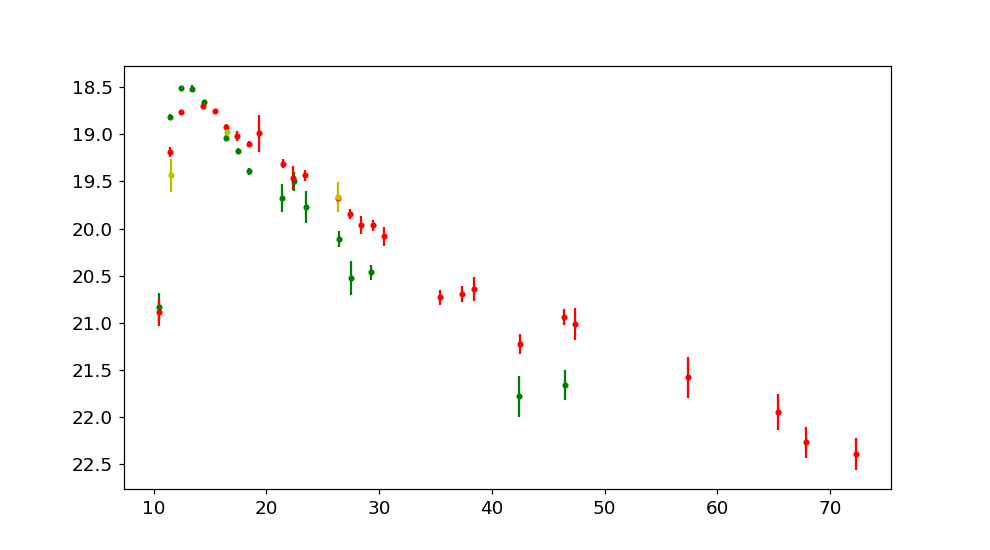

In [27]:
see_mags(lc, SNT = 5, xlabel = "mjd")
#plt.xlim(10, 65.5)

In [28]:
#see_mags(newlc, SNT = 5, xlabel = "mjd")

from astropy.time import Time

In [29]:
from astropy.time import Time
times = ['2019-04-10T00:00:00', '2019-04-11T00:00:00']
t = Time(times, format='isot', scale='utc')

In [30]:
t.jd

array([2458583.5, 2458584.5])

In [31]:
t.mjd

array([58583., 58584.])

UTC is eight hours ahead of PST (Palomar Mountain), so the same night of observations will be within the same UT date. i.e., within the consecutive integers of `MJD`!

I decide to go with `SNT = 5` since there is no subthreshold detections to be picked up by setting `SNT = 3`.

In [32]:
SNT=5
Fratio = lc["Fratio"].values
Fratio_unc = lc["Fratio_unc"].values
ix = Fratio > SNT*Fratio_unc

In [33]:
from copy import deepcopy

In [34]:
det = deepcopy(lc[ix])
nondet = deepcopy(lc[~ix])

In [35]:
mags = -2.5 * np.log10(Fratio[ix])
emags = 2.5 / np.log(10) * Fratio_unc[ix] / Fratio[ix]
det["mag"] = mags
det["mag_unc"] = emags

In [36]:
nondet["limmag"] = -2.5 * np.log10(5 * Fratio_unc[~ix])

In [37]:
det.head()

,mjd,Fratio,Fratio_unc,filterid,mag,mag_unc
6,58580.442068,4.662626e-09,6.360845e-10,1.0,20.828423,0.148118
7,58581.480723,2.984845e-08,9.086675e-10,1.0,18.812696,0.033053
8,58582.439624,3.963762e-08,6.916037e-10,1.0,18.504731,0.018944
9,58583.408160,3.924609e-08,1.330218e-09,1.0,18.515509,0.036800
10,58584.469077,3.456897e-08,4.941996e-10,1.0,18.653284,0.015522


In [38]:
nondet.head()

,mjd,Fratio,Fratio_unc,filterid,limmag
0,58568.427998,5.566371e-10,6.668843e-10,1.0,21.192449
1,58569.429549,-1.889837e-09,1.469067e-09,1.0,20.334971
2,58572.502491,-5.095498e-10,4.245363e-10,1.0,21.682788
3,58573.482679,3.398476e-10,5.239076e-10,1.0,21.454438
4,58574.433137,-5.597584e-10,5.326942e-10,1.0,21.436380


In [39]:
det.to_csv("../data/photometry/P48/detection.csv", index = False)
nondet.to_csv("../data/photometry/P48/upperlim.csv", index = False)

In [40]:
nondet = nondet.sort_values(by = "mjd")

In [41]:
nondet = nondet[nondet["mjd"]<min(det["mjd"].values)]

First alert packet (that passed the Fast Transient filter) is at MJD = 58581.4 (Apr 8), while first forced photometry detection is at 58580.4 (Apr 7)!

In [42]:
t_upp = Time(nondet["mjd"].values[-1], format="mjd")

In [43]:
t_upp.datetime64

numpy.datetime64('2019-04-04T09:49:55.004153252')

In [44]:
nondet["limmag"].values[-1]

18.95423824533113

In [45]:
t_det = Time(min(det["mjd"].values), format="mjd")

In [46]:
t_det.datetime64

numpy.datetime64('2019-04-07T10:36:34.669447630')

### 4. Numbers to be reported in paper --- from Marshal

In [47]:
t_det = Time(2458580.9297, format="jd")

In [48]:
mag = 20.66
magerr = 0.34

In [49]:
t_det.datetime64

numpy.datetime64('2019-04-07T10:18:46.080018282')

In [50]:
ra = 264.1948515
dec = 50.5479144

In [51]:
from astropy.coordinates import SkyCoord
coo = SkyCoord(ra = ra, dec = dec, unit = 'degree')

In [52]:
coo.ra.hms

hms_tuple(h=17.0, m=36.0, s=46.76436000001672)

In [53]:
coo.dec.dms

dms_tuple(d=50.0, m=32.0, s=52.491840000012076)

#### Upper limit On Marshal: jd = 2458577.9096, limmag = 18.39

### 5. Pre-explosion detection?
- 2014 May 27	2456804.9374	r	-13.80	20.97	0.15	21.25	P48+iPTF	1	None	True	True	0.327
- 2014 Jun 07	2456815.9641	r	-13.76	21.02	0.18	21.11	P48+iPTF	1	None	True	True	0.414

#### iPTF forced photometry service
save the light curve to `../data/photometry/P48/iPTF/`

In [72]:
import astropy.io.ascii as asci

In [112]:
myfile = '../data/photometry/P48/iPTF/forcepsffitdiff_d4790_f2_c7.out'
tb = asci.read(myfile, format = "ipac")
tb = tb.to_pandas()

In [113]:
tb.rename(columns={'flux':'Fpsf',
                   'sigflux':'Fpsf_unc',
                   'zpmag':'zp',
                   'zprms':'ezp',
                   'MJD': 'mjd'}, inplace=True)
tb = tb.drop(columns = ["xpos", "ypos"])

In [114]:
    print (len(tb))
    tb = tb[tb.ezp<0.15]
    print (len(tb))
    F0 = 10**(tb['zp'].values/2.5)
    eF0 = F0 / 2.5 * np.log(10) * tb['ezp'].values
    Fpsf = tb['Fpsf'].values
    eFpsf = tb['Fpsf_unc'].values
    Fratio = Fpsf / F0
    eFratio2 = (eFpsf / F0)**2 + (Fpsf * eF0 / F0**2)**2
    eFratio = np.sqrt(eFratio2)
    tb['Fratio'] = Fratio
    tb['Fratio_unc'] = eFratio

178
173


<IPython.core.display.Javascript object>


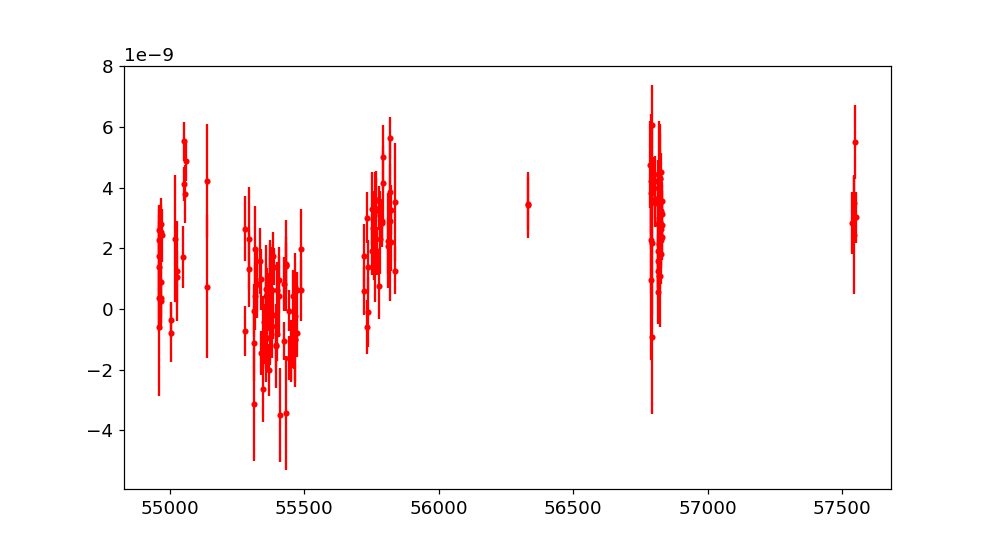

<ErrorbarContainer object of 3 artists>

In [115]:
plt.figure(figsize=(9, 5))
plt.errorbar(tb['mjd'].values, tb['Fratio'].values, tb['Fratio_unc'].values, fmt='.r')

In [116]:
mjd0 = min(tb['mjd'].values)
mjd1 = max(tb['mjd'].values)

In [121]:
t0 = Time(mjd0, format = "mjd")
t1 = Time(mjd1, format = "mjd")

In [120]:
t0.datetime64

numpy.datetime64('2009-05-07T04:29:29.759999821')

In [122]:
t1.datetime64

numpy.datetime64('2016-06-13T10:43:14.880000036')